In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd, os, re, numpy as np
%matplotlib inline

In [3]:
import seaborn as sns

In [4]:
from clustergrammer_widget import *

In [5]:
samples = pd.read_pickle('../data/full_sample_df.pkl')

In [6]:
samples = samples[samples.sequencing_context != 'rna seq']

In [7]:
#keep tumor normal pairs
samples = samples[samples.tumor_normal_pair]

In [8]:
review_df = pd.read_pickle('../data/review_df.pkl')

In [9]:
review_df.project = review_df.project.str.strip()

In [10]:
#filter to only tumor normal pairs
review_df = review_df[review_df.individual_name.isin(list(samples.individual_name.unique()))]

In [11]:
review_df.drop_duplicates(inplace=True)

In [12]:
from zero_one_based_conversion import convert

In [13]:
def convert_one_based(row):
    return convert.coordinate_system('\t'.join(map(str,row.values)), 'to_one_based').split('\t')

In [14]:
review_df_one_based = review_df.apply(convert_one_based, axis=1)

Coordinate Error in line 1 or input. Coordinate skipped.
	Message: For the coordinate 11:51579262-51579264->T, the reference and variant fields indicate an insertion variant, however the coordinates (51579262 and 51579264) are not valid for these mutation types.
Coordinate Error in line 1 or input. Coordinate skipped.
	Message: For the coordinate 1:36728386-36728388->T, the reference and variant fields indicate an insertion variant, however the coordinates (36728386 and 36728388) are not valid for these mutation types.
Coordinate Error in line 1 or input. Coordinate skipped.
	Message: For the coordinate 1:34510640-34510642->AT, the reference and variant fields indicate an insertion variant, however the coordinates (34510640 and 34510642) are not valid for these mutation types.
Coordinate Error in line 1 or input. Coordinate skipped.
	Message: For the coordinate 11:51579262-51579264->T, the reference and variant fields indicate an insertion variant, however the coordinates (51579262 and

	Message: For the coordinate 5:158524095-158524099GGC>0, the reference and variant fields indicate an deletion or substitution variant, however the coordinates (158524095 and 158524099) are not valid for these mutation types.
Coordinate Error in line 1 or input. Coordinate skipped.
	Message: For the coordinate 6:157528578-157528581CT>0, the reference and variant fields indicate an deletion or substitution variant, however the coordinates (157528578 and 157528581) are not valid for these mutation types.
Coordinate Error in line 1 or input. Coordinate skipped.
	Message: For the coordinate 7:105733551-1057335500>A, the reference and variant fields indicate an insertion variant, however the coordinates (105733551 and 105733550) are not valid for these mutation types.
Coordinate Error in line 1 or input. Coordinate skipped.
	Message: For the coordinate 8:38884345-388843440>T, the reference and variant fields indicate an insertion variant, however the coordinates (38884345 and 38884344) are 

In [15]:
len(review_df)

37342

In [16]:
review_df_one_based = review_df_one_based.replace('',np.nan).dropna(how='all')
len(review_df_one_based)

37201

In [17]:
review_df_one_based.project = review_df_one_based.project.str.strip()

In [18]:
group = review_df_one_based.groupby(['individual_name'])

In [19]:
duplicated = group.project.apply(lambda x: len(x.unique()))

In [20]:
duplicated = duplicated[duplicated >1].index.tolist()

In [21]:
compare_group = review_df_one_based.groupby(['project','individual_name'])

In [22]:
#find dups ignoring project
compare_group = review_df_one_based.groupby(['individual_name'])

In [23]:
def group_percent_similar(group1, group2):
    g1= group1[['chr','start','stop','ref','var']]
    g2 = group2[['chr','start','stop','ref','var']]
    g = pd.concat([g1,g2])
    return len(g[g.duplicated()])/(len(g)- len(g[g.duplicated()]))

In [24]:
names = ['__'.join(x) for x in compare_group.groups.keys()]
compare_calls = pd.DataFrame(index=names, columns=names)
for name1, group1 in compare_group:
    for name2, group2 in compare_group:
        compare_calls.set_value('__'.join(name1), 
                                '__'.join(name2), 
                                group_percent_similar(group1, group2))

In [25]:
compare_calls.to_pickle('../data/compare_calls.pkl')

In [26]:
compare_calls = pd.read_pickle('../data/compare_calls.pkl')

In [27]:
compare_calls = compare_calls.astype(float)

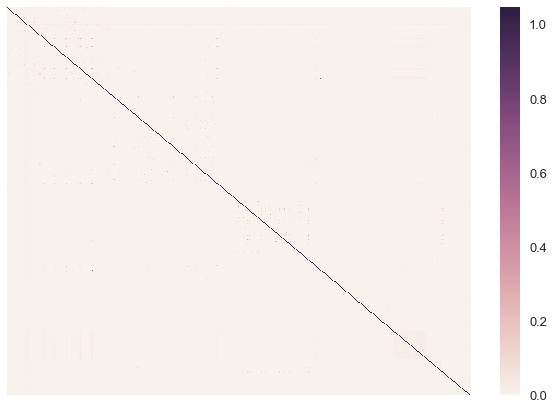

In [28]:
sns.set_context("talk")
heatmap = sns.heatmap(compare_calls, xticklabels=False, yticklabels=False)

In [29]:
# fig = heatmap.get_figure()
# fig.savefig("output.png")

In [30]:
net = Network(clustergrammer_widget)
net.load_df(compare_calls)
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [31]:
mask = np.ones(compare_calls.shape, dtype='bool')
mask[np.triu_indices(len(compare_calls))]=False
m = mask & (compare_calls!=0)

compare = compare_calls.mask(~m).unstack().dropna()

## All samples with at greater than 0.7 percent similarity were removed

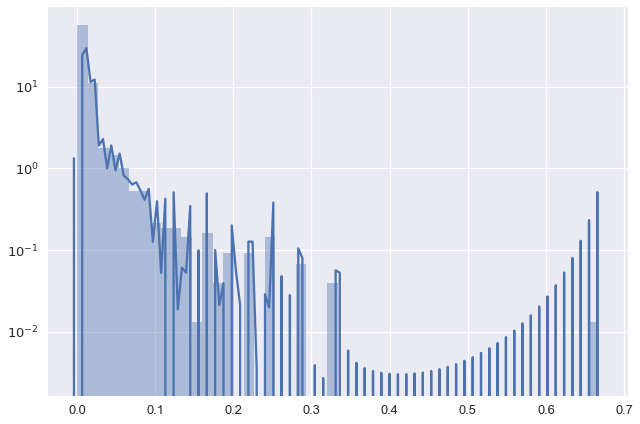

In [32]:
sns.distplot(compare)
plt.yscale('log')